In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.data.some_dataloader import *
import matplotlib.pyplot as plt
from article_to_country import *

### This notebooks shows how the countries are extracted from the wikipedia plaintext articles

First a naive approach is used by doing a text search and finding all the country string names inside the plaintext.

In [3]:
country_data = country_occurences_in_files()
counts = filter_top_k(country_data, k=2, N=1)

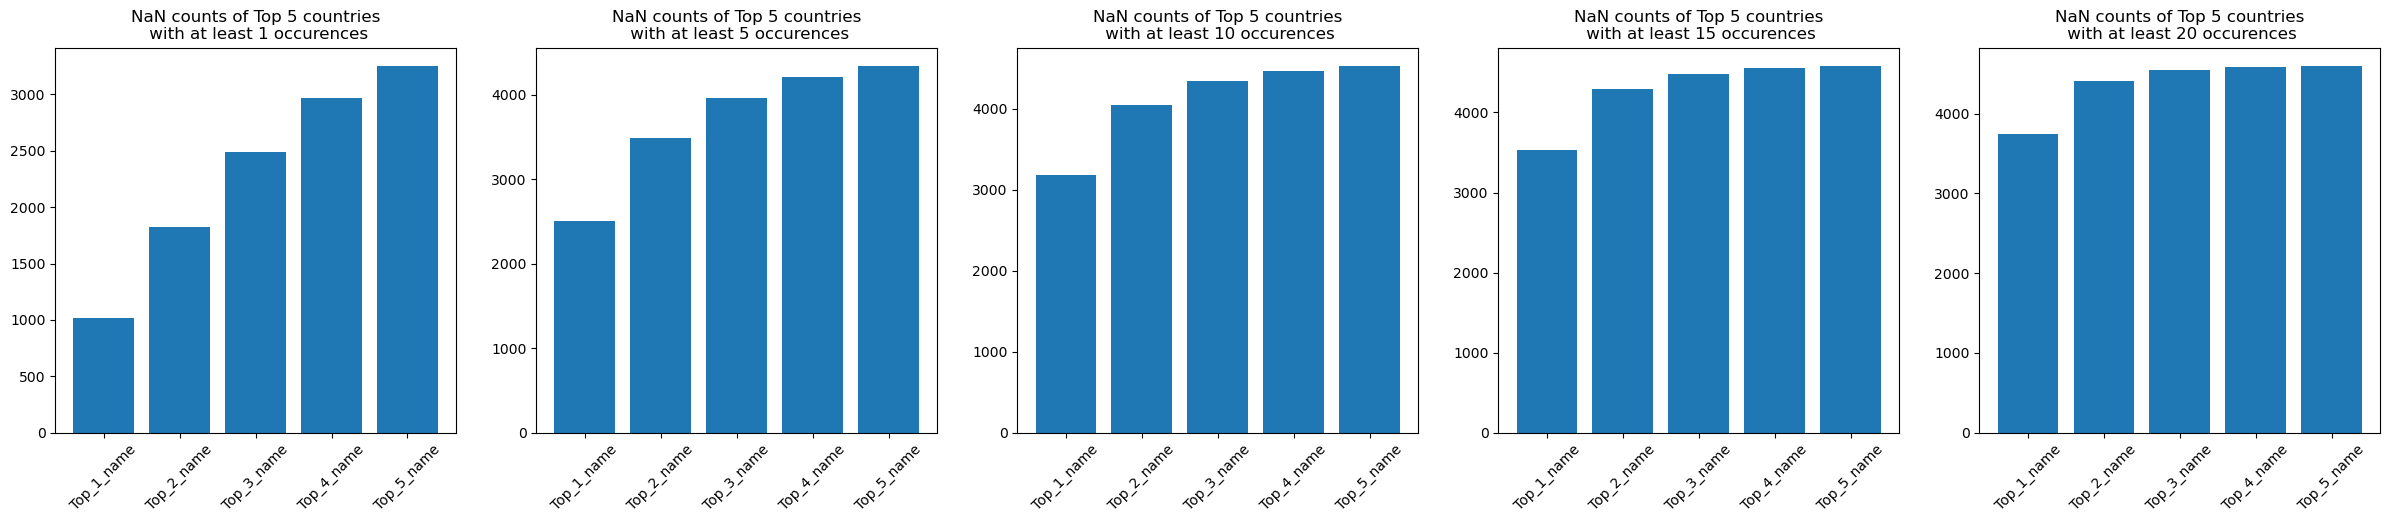

In [4]:
N_samples = [1, 5, 10, 15, 20]
K = 5

fig, axs = plt.subplots(1, len(N_samples), figsize=(30, 5))

i = 0
for j, N in enumerate(N_samples):
    counts = filter_top_k(country_data, k=K, N=N)
    df_cleaned = counts.iloc[:, :K]
    df_stat = df_cleaned.isna().sum()
    axs[j].bar(df_stat.index, df_stat)
    axs[j].set_title(f"NaN counts of Top {K} countries\n with at least {N} occurences")
    
    axs[j].xaxis.set_tick_params(rotation=45)

From the previous cell it was clear that in order to classify the articles we needed to pick a small number of occurences (N = 1) in order to avoid discarding more than half of the articles. 

In [5]:
nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")


Number of articles with no countries before completion with llama: 3740


This approach resulted in 1015 articles having no country assigned to them. By going manually through them it can be seen that as a human some articles can be further classified to countries even if not explicitely mentionned in the text. 

### Further classifying articles to countires with the help of small llm's

Two LLM's were tested and only Llama (a Meta LLM) was retained in order to assign the missing articles to countries. Fot this to be done the LLM was downloaded locally and used for inference on the plaintext articles. 

The format of the prompt used to let the model classify articles to countries was : 
```
<system_prompt_begin>
You will be given textual articles. For each article provide single and unique country to which the article is related and should be classified to. Provide the answer in the form : <country>. If there is no country related to the article, please write 'None'. If the location is not on earth, please write 'None'. You must be 100\% sure this is a question of life or death.
<system_prompt_end>

<user_prompt_begin>
plaintext article
<user_prompt_end>
```

In order to run this execute the following cell : 
Note : It was already preprocessed so this can also be skipped and the  ```data/country_occurences_inferrence.csv``` can be loaded

In [6]:
# !python article_to_country.py

In [8]:
refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with llama: {len(nan_df)}")

Number of articles with no countries after completion with llama: 644


This approach allowed to classify 1015 - 508 = 507 new articles having no country assigned to them. In the cell below it can be seen which articles were classified with help of the LLM (the ones having a "Top_1_count" of 0 meaning 0 occurences of this exact substring in the text but still classified as this country by the llm)

In [9]:
refined_data[refined_data["Top_1_count"] == 0].head(10)

,Top_1_name,Top_2_name,Top_1_count,Top_2_count
1980_eruption_of_Mount_St._Helens,united states,NaN,0.0,NaN
4-2-0,united states,NaN,0.0,NaN
4-6-0,united states,NaN,0.0,NaN
6-2-0,united states,NaN,0.0,NaN
8th_century,united kingdom,NaN,0.0,NaN
Abbadid,spain,NaN,0.0,NaN
Abstract_art,russia,NaN,0.0,NaN
Achilles_tendon,greece,NaN,0.0,NaN
African_Black_Oystercatcher,south africa,NaN,0.0,NaN
African_clawed_frog,south africa,NaN,0.0,NaN


Text(0.5, 1.0, 'Top 40 countries occurences in the articles')

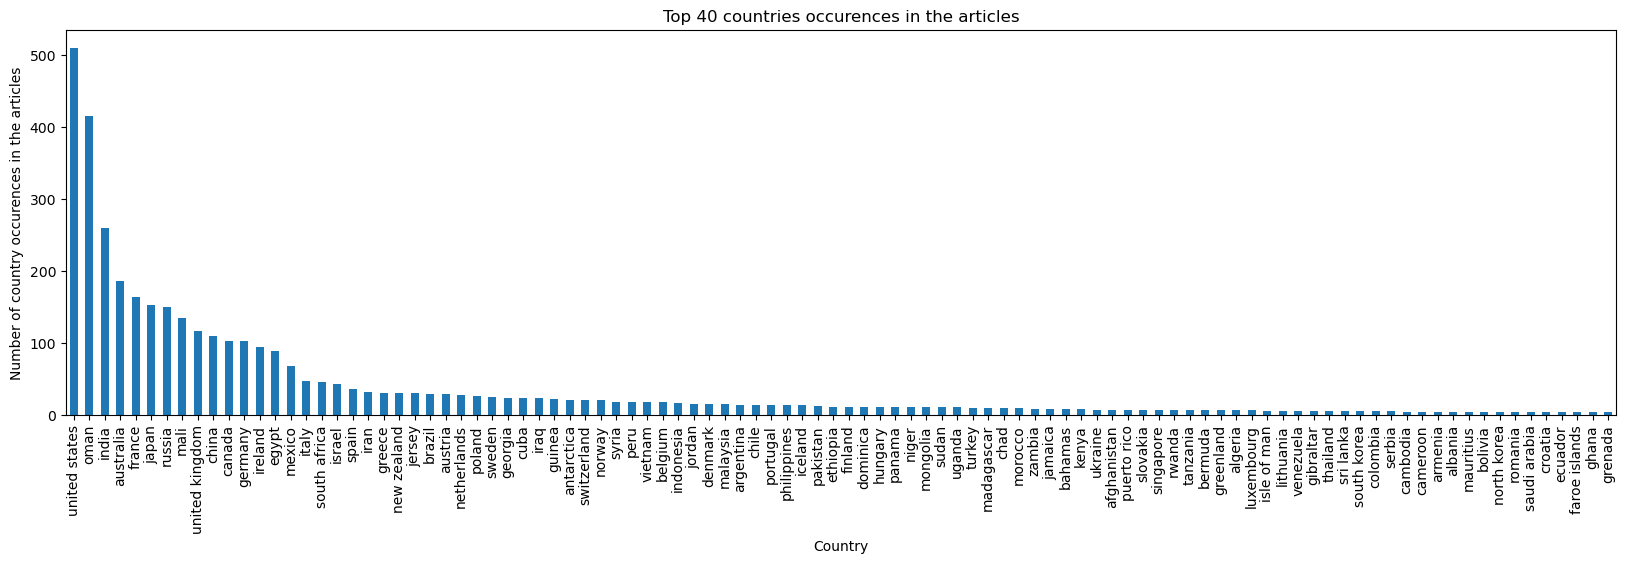

In [10]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Top 40 countries occurences in the articles")

Text(0.5, 1.0, 'Top 40 countries occurences in the articles')

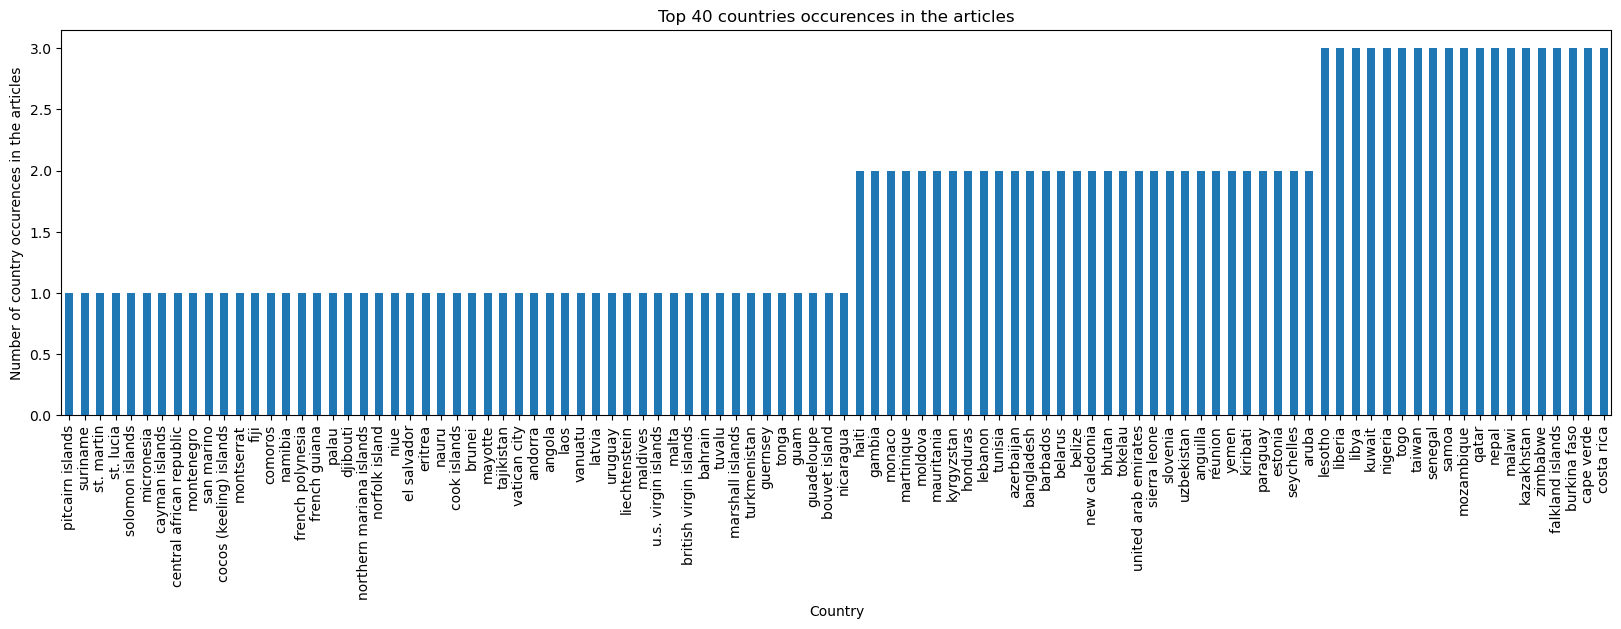

In [11]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=True).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Top 40 countries occurences in the articles")

### Analysis of country relations between articles and outgoing links

In [81]:
from ast import literal_eval
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].fillna("[]")
country_clicks["num_links_in"] = country_clicks["num_links_in"].fillna(0)
country_clicks["num_links_out"] = country_clicks["num_links_out"].fillna(0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].apply(literal_eval)

In [ ]:
l = []

for idx, row in country_clicks.iterrows():
    links_out_list = list(row["name_links_out"])
    for out_link in links_out_list:
        l.append(f"{row['Top_1_name']} -> {country_clicks.loc[out_link]['Top_1_name']}")

Text(0.5, 1.0, 'Top 100 country links by occurences')

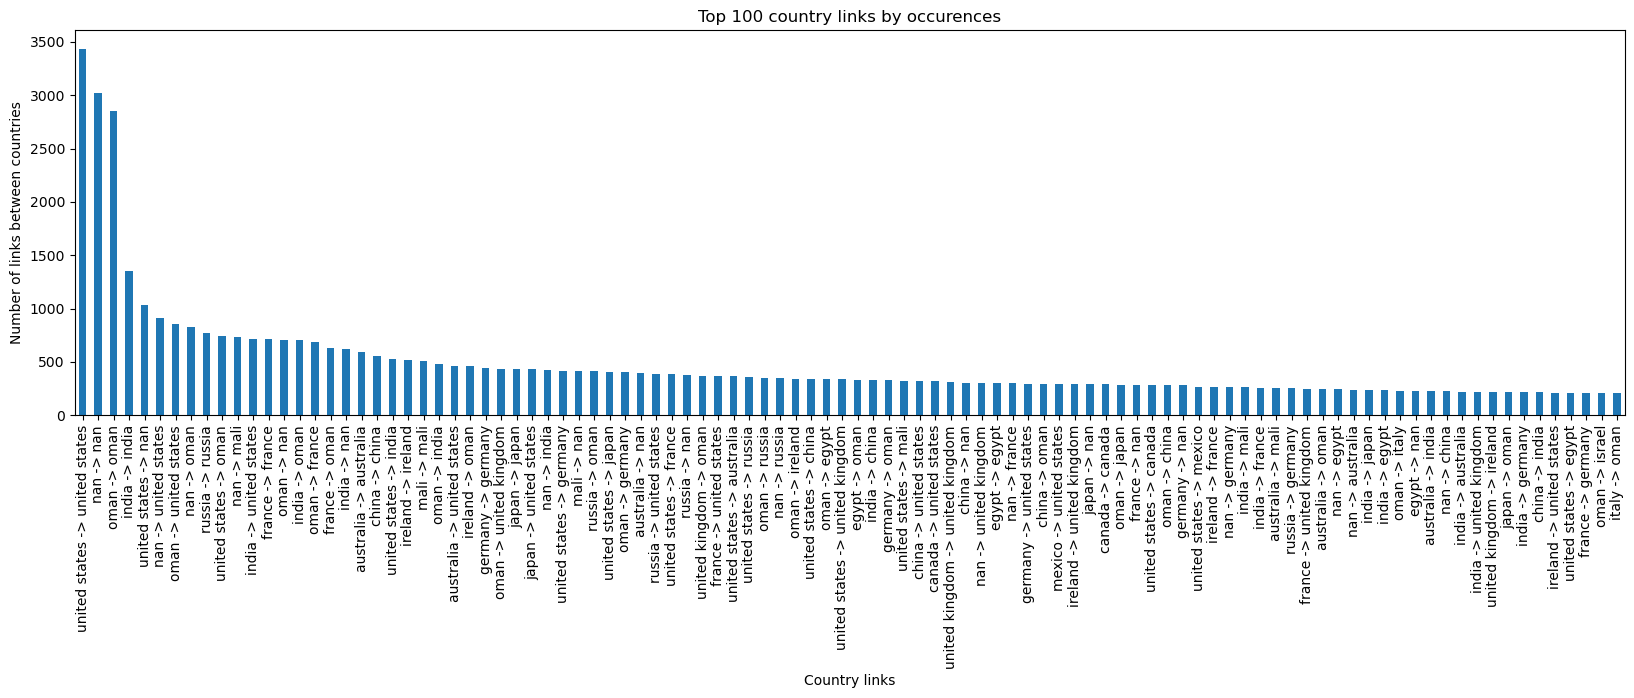

In [69]:
df = pd.DataFrame(l, columns=["links"])
df.groupby("links").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))
plt.ylabel("Number of links between countries")
plt.xlabel("Country links")
plt.title("Top 100 country links by occurences")

It can be seen that articles of one country are always strongly interconnected. In the sense that once the user is inside articles assigned to a specific country, they have larger chances to stay in articles of the sam country by clicking on links to navigate to other articles.

### Analysis of the countries relations between the start and the end of finished paths.

In [92]:
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

finished_paths["path"] = finished_paths["path"].str.split(";")
unfinished_paths["path"] = unfinished_paths["path"].str.split(";")

def paths_to_country(df):
    l = []
    for idx, row in df.iterrows():
        start_article = row["path"][0]
        end_article = row["path"][-1]
        
        if start_article != '<' and end_article != '<':
        
            start_country = country_clicks.loc[start_article]["Top_1_name"]
            end_country = country_clicks.loc[end_article]["Top_1_name"]
            
            l.append(f"{start_country} -> {end_country}")
    return pd.DataFrame(l, columns=["links"])

finished_df = paths_to_country(finished_paths)
unfinished_df = paths_to_country(unfinished_paths)
    

Text(0.5, 1.0, 'Top 100 country connections between the start and end of a finished path')

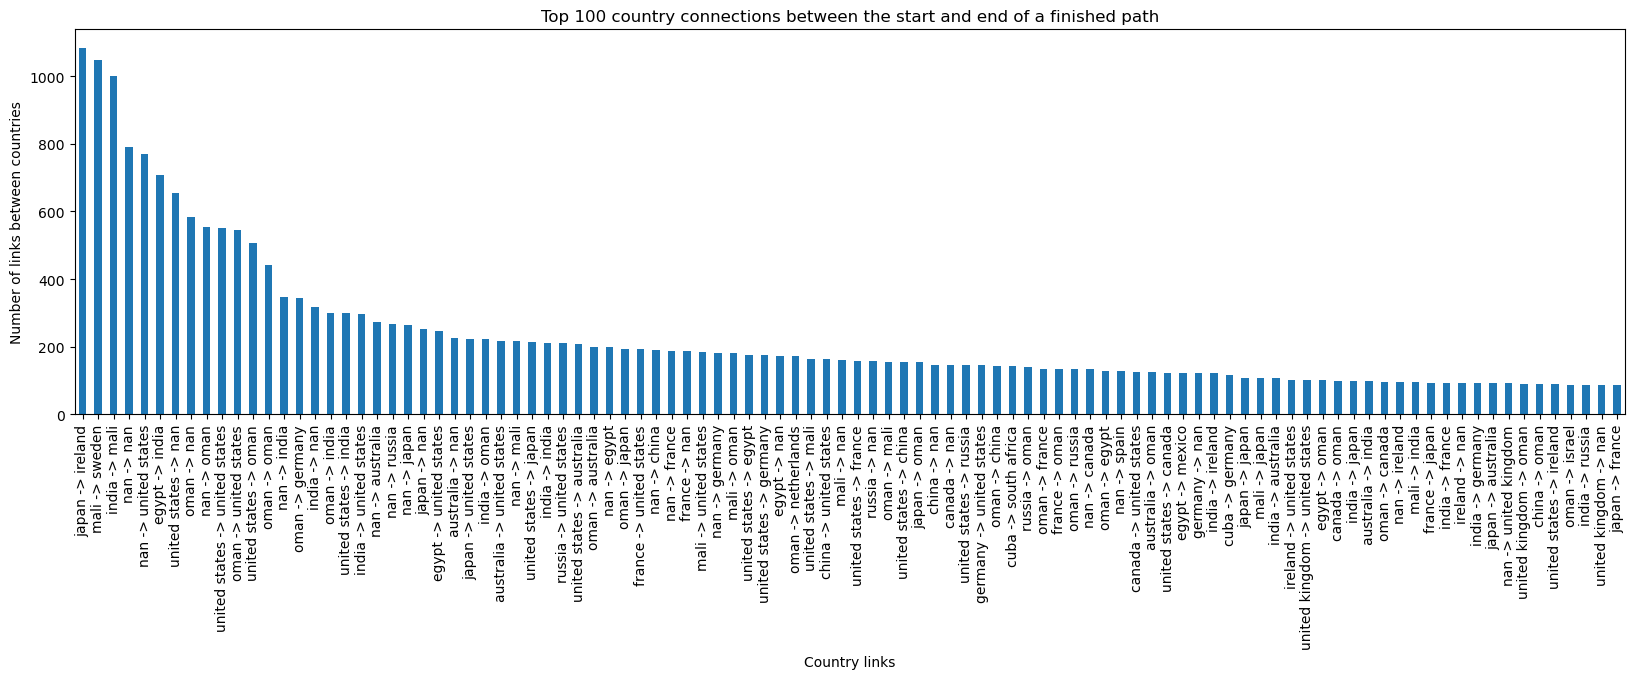

In [95]:
finished_df.groupby("links").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))
plt.ylabel("Number of links between countries")
plt.xlabel("Country links")
plt.title("Top 100 country connections between the start and end of a finished path")

Text(0.5, 1.0, 'Top 100 country connections between the start and end of an unfinished path')

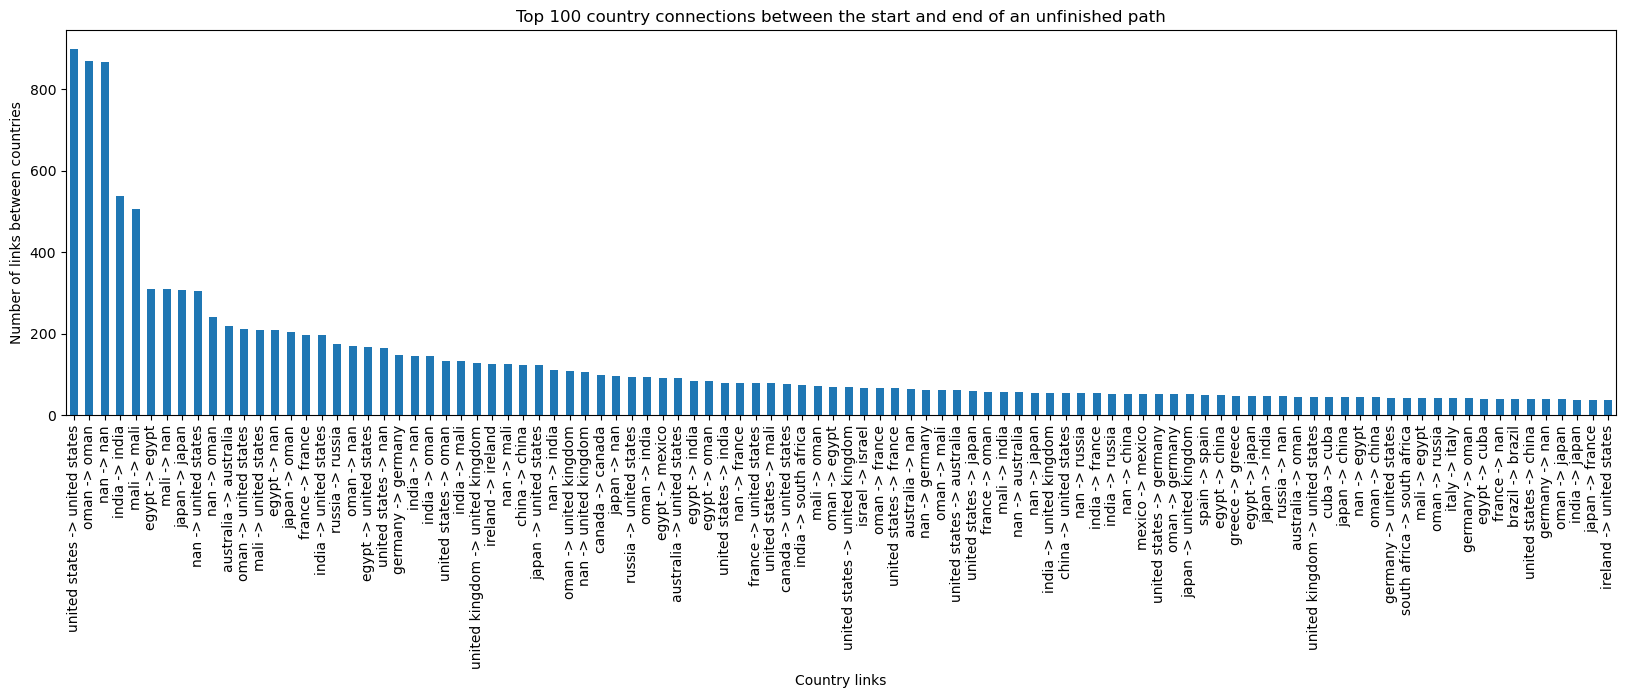

In [96]:
unfinished_df.groupby("links").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))
plt.ylabel("Number of links between countries")
plt.xlabel("Country links")
plt.title("Top 100 country connections between the start and end of an unfinished path")

This shows that when the start country and end country of a path are the same then the player has less chances to finish the path.

### Statistical analysis : trying to predict the number of clicks an article is getting from the data.

The first approach is based on the fact that we observed that a lot of articles are classified into 2 predominant countries categories. We thus thought that the country category could have an impact on the number of clicks an article is getting. 
We used an ordinary least squares solver in order to describe this data and tried to predict : 
```click_count ~ num_links_in + num_links_out + C(Top_1_name)```
The number of incoming/outgoing links can also be seen as a useful feature in order to predict the number of clicks an article recieves so this is why there are also included. 

In [ ]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='click_count ~ num_links_in + num_links_out + C(Top_1_name)', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     34.38
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:33:16   Log-Likelihood:                -26457.
No. Observations:                3960   AIC:                         5.333e+04
Df Residuals:                    3750   BIC:                         5.465e+04
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

By analysing the coefficients we see that we can reject the fact that the countires have a meaningful impact on the number of clicks an article recieves at a significant level.
Given the results the only variable we can't reject at a significant level is the ```num_links_in```. We will thus further analyse this with a simpler model :  
```click_count ~ num_links_in```

In [82]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='click_count ~ num_links_in', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     7981.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:53:32   Log-Likelihood:                -30676.
No. Observations:                4604   AIC:                         6.136e+04
Df Residuals:                    4602   BIC:                         6.137e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.3887      3.023     -2.444   

In this case it can be seen that the both the intercept and the num_links_in coefficients are significant at 85% and are thus significant in order to predict the number of clicks an articles recieves. This means that the number of incoming links is related to the number of clicks an article has and moreover each incoming links increases the chance of an article to be clicked by nearly 4. 

We will provide a last analysis trying to see if the number of outgoing links are significant to the number of clicks an article recieves. 
The formula used for this is : ```click_count ~ num_links_in * num_links_out``` so that the cross term is also present.

In [85]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='click_count ~ num_links_in * num_links_out', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     4804.
Date:                Sun, 10 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:59:25   Log-Likelihood:                -29725.
No. Observations:                4604   AIC:                         5.946e+04
Df Residuals:                    4600   BIC:                         5.948e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Text(0.5, 1.0, 'Coefficients of the linear regression model')

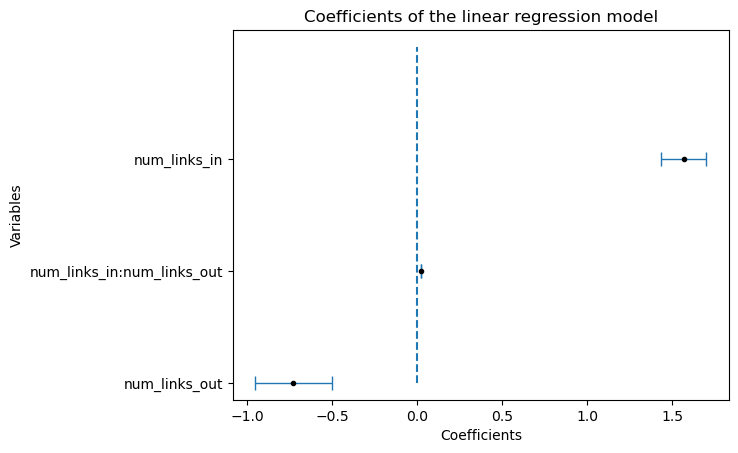

In [87]:
variables = res.params.index
coefficients = res.params.values
p_values = res.pvalues
standard_errors = res.bse.values
res.conf_int()

# plt.figure(figsize=(10, 10))
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);


plt.xlabel('Coefficients')
plt.ylabel('Variables')
plt.title('Coefficients of the linear regression model')


The results suggest that the number of incoming and outgoing links, as well as the interaction between them, significantly contribute to predicting the click count on an article. Specifically:

Number of Incoming Links (num_links_in): Each additional incoming link is associated with an increase of approximately 1.57 clicks on average (coefficient: 1.57). This positive coefficient implies that the more links pointing to an article, the higher its visibility and the potential clicks it receives. This effect is statistically significant with a very low p-value (<0.001).

Number of Outgoing Links (num_links_out): Each outgoing link reduces the click count by about 0.73 clicks (coefficient: -0.73), suggesting that articles with more outgoing links may divert readers attention away, leading to fewer clicks. This negative effect is also statistically significant (p < 0.001).

Interaction between Incoming and Outgoing Links (num_links_in:num_links_out): The positive interaction term (coefficient: 0.021) indicates that articles with both high incoming and outgoing links experience a slightly amplified effect on click count. This means that for articles with many incoming links, the negative effect of outgoing links is somewhat mitigated. This subtle effect is also significant (p < 0.001).

Overall Model Fit
R-squared: The R-squared value of 0.758 suggests that approximately 75.8% of the variance in click counts is explained by this model, which indicates a good fit.
F-statistic: The high F-statistic (4804) with a p-value near zero confirms that the model is statistically significant overall.

In [84]:
country_clicks[['num_links_in', 'num_links_out','click_count']].corr()

,num_links_in,num_links_out,click_count
num_links_in,1.000000,0.542424,0.796409
num_links_out,0.542424,1.000000,0.420785
click_count,0.796409,0.420785,1.000000
